# Bachelor Notebook

## Import Statements

contains the import statements for all necessary packages

In [6]:
from os import listdir
from os.path import isfile, join
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from fastai.data.all import *
from fastai.vision.all import *
#from fastai.vision.image import *
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
import shutil
from PIL import Image
from matplotlib.pyplot import imshow
#from IPython.core.debugg

## Define paths
define the paths to the relevant data

In [3]:
data_path=r"D:\Bachelor\data"
image_path=data_path+r"\ImageFiles"
ship_image_path=image_path+r"\ships"
ship_csv_path=data_path+r"shipsAIS_2017_Zone17.csv"
nonship_image_path=image_path+r"\non_ships"
nonship_csv_path=data_path+r"\nonshipsAIS_2017_Zone17.csv"

## Search for misplaced directories
Some image directories are misplaced, instead of being located in ships or nonships, certain subdirectories are located in other subdirectories. The following method finds the affected subdirectories and prints them.

In [ ]:
def get_misplaced_directories(path):
    misplaced_directories=[]
    for d in listdir(path):
        if os.path.isdir(join(path,d)):
            for f in listdir(join(path,d)):
                if os.path.isdir(join(join(path,d),f)):
                    misplaced_directories.append(join(path,d))
    return misplaced_directories

In [ ]:
get_misplaced_directories(ship_image_path)

In [ ]:
get_misplaced_directories(nonship_image_path)

## Correct misplaced directories
The following two methods correct the location of the aforementioned misplaced subdirectories.

In [ ]:
def correct_misplaced_directories(path):
    misplaced_directories=[]
    main_dir=listdir(path)
    for d in main_dir:
        sub_dir=join(path,d)
        if os.path.isdir(sub_dir):
            for f in listdir(sub_dir):
                current_path=join(sub_dir,f)
                if os.path.isdir(current_path):
                    #misplaced_directories.append(current_directory)
                    correct_misplaced_directories_r(path,current_path)
                    #correct dir
                    if f in main_dir:
                        shutil.rmtree(current_path)
                    else:
                        shutil.move(current_path,path)

def correct_misplaced_directories_r(main_path,path):
    main_dir=listdir(main_path)
    for d in listdir(path):
        current_path=join(path,d)
        if os.path.isdir(current_path):
            correct_misplaced_directories_r(main_path,current_path)
            #correct dir
            if d in main_dir:
                shutil.rmtree(current_path)
            else:
                shutil.move(current_path,main_path)
        

In [ ]:
correct_misplaced_directories(ship_image_path)
correct_misplaced_directories(nonship_image_path)

## Test

In [4]:
nonship_image_files = []# [f for f in dir1 for dir1 in listdir(nonship_image_path) if isfile(join(nonship_image_path,join(dir, f))) and ".tif" in f]
for directory in listdir(nonship_image_path):
    nonship_image_files+=[join(join(nonship_image_path,directory),f) for f in os.listdir(join(nonship_image_path,directory)) if ".tif" in f and "udm" not in f]
#ship_image_files = [f for f in listdir(ship_image_path) if isfile(join(ship_image_path, f))]
#ship_image_files = []# [f for f in dir1 for dir1 in listdir(nonship_image_path) if isfile(join(nonship_image_path,join(dir, f))) and ".tif" in f]
ship_image_files=[]
for directory in listdir(ship_image_path):
    ship_image_files+=[join(join(ship_image_path,directory),f) for f in os.listdir(join(ship_image_path,directory)) if ".tif" in f and "udm" not in f]
nonship_images=[rasterio.open(f) for f in nonship_image_files]
ship_images=[rasterio.open(f) for f in ship_image_files] 

<IPython.core.display.Javascript object>


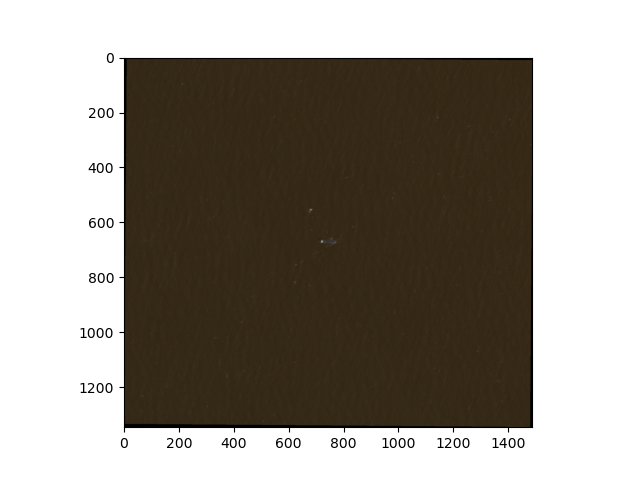

In [20]:
%matplotlib notebook
sim=ship_images[0]
arr=sim.read()
arr=np.swapaxes(arr,0,2)
#print(arr.shape)
arr=arr[:,:,:3]
m=arr.max()
#print(arr.min())
arr=arr/(m+1)*255
imshow(arr.astype(np.uint8))#,norm=matplotlib.colors.Normalize(0,32000))
#print(arr.astype(np.uint8).max())
#print(arr.astype(np.uint8).min())

## Test ImageReading

In [36]:
sim=ship_images[0]
arr=sim.read()
arr=np.swapaxes(arr,0,2)
#print(arr.shape)
arr=arr[:,:,:3]
m=arr.max()
#print(arr.min())
arr=arr/(m+1)*255
img=Image.fromarray(arr.astype(np.uint8),"RGB")
img.show()

In [ ]:

images=DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=(),
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


In [ ]:
get_image_files??

In [ ]:
get_files??

In [ ]:
L??

In [ ]:
type(get_image_files(ship_image_path))
#type(get_image_files(ship_image_path)[0])

In [ ]:
type(get_4ch_tif_files(ship_image_path))

## Getter functions
definition of get_items and get_y for DataBlocks

In [22]:
def get_4ch_tif_files(path):
    file_paths=[]
    for root,directories,files in os.walk(path):
        #print(root)
        file_paths+=[Path(join(root,f)) for f in files if ".tif" in f and "udm" not in f]
    return L(file_paths)

def get_data_y(item):
    return Path(item).parent.parent.name

## Modified TensorImage

In [82]:
class TensorImage4D(TensorImage):
    def show(self, ctx=None, **kwargs):
        rgbTensor=self[:3,:,:]
        return show_image(rgbTensor, ctx=ctx, **{**self._show_args, **kwargs})
        

## Transform functions
transformation functions for the independent variable

In [83]:
width=-1
height=-1


def get_image(item):
    img=rasterio.open(item)
    b,g,r,n=img.read()
    channels=tuple([r,g,b,n])
    arr=np.dstack(channels)
    arr=(arr/32000)*255
    #print(arr.shape)
    arr=(arr).astype(np.uint8)
    #img = Image.fromarray(arr[:,:,:3], 'RGB')
    #img.show()
    t=TensorImage4D(image2tensor(torch.Tensor(arr[:,:,:])))
    t=t.type(torch.uint8)
    #print(t.dtype)
    #print(torch.max(t))
    #print(torch.min(t))
    #t.show()
    #print(t.shape)
    return t

class crop_middle(Transform):
    def __init__(self, size=400, randomnes=25):
        self.size = size
        self.randomnes = randomnes
    def encodes(self, x:TensorImage):
        #print("encodes() called")
        #data = x[0]
        data=x
        rows = data.shape[1]
        #cols = data.shape[2]
        cols = data.shape[2]
        # select the positions, cut and create the image
        mid_row = int(rows/2)
        mid_col = int(cols/2)
        start_row = mid_row - int(self.size/2)
        start_col = mid_col - int(self.size/2)
        # randomly disturb the starting positions so the ships are not in the middle
        col_dist, row_dist = np.random.randint(low=-self.randomnes, high=self.randomnes, size=2)
        start_row += row_dist
        start_col += col_dist
        # cut array
        #print(data.shape)
        data = data[:,start_row : start_row+self.size, start_col: start_col+self.size]
        #print(data.shape)
        return data


                  
def to_tensor(img):
    return torch.Tensor(img)



In [ ]:
def equalize_size(img):
    #print("equalizing size")
    global width
    global height
    
    size_diff_width=img.shape[0]-width
    size_diff_height=img.shape[1]-height
    low_width,high_width,low_height,high_height=0,0,0,0
    img_width,img_height=img.shape[0],img.shape[1]
    if size_diff_width%2==0:
        low_width=int(size_diff_width/2)
        high_width=int((img_width-1)-size_diff_width/2)
    else:
        low_width=int((size_diff_width-1)/2)
        high_width=int((img_width)-((size_diff_width-1)/2))
    if size_diff_height%2==0:
        low_height=int(size_diff_height/2)
        high_height=int((img_height-1)-size_diff_height/2)
    else:
        low_height=int((size_diff_height-1)/2)
        high_height=int((img_height)-((size_diff_height-1)/2))
    return img[low_width:high_width,low_height:high_height,:]

def get_smallest_dimensions(path):
    #print(path)
    global width
    global height
    for first_dir in listdir(path):
        path_2=join(path,first_dir)
        for second_dir in listdir(path_2):
            path_3=join(path_2,second_dir)
            #print(path_3)
            for file in listdir(path_3):
                if ".tif" in file and "udm" not in file:
                    im=rasterio.open(join(path_3,file))
                    dim=im.read(1).shape
                    if width==-1:
                        width=dim[0]
                    elif width>dim[0]:
                        width=dim[0]
                    if height==-1:
                        height=dim[1]
                    elif height>dim[1]:
                        height=dim[1]

## Load Data
definition of the DataBlock

In [ ]:
Resize??

In [84]:
images=DataBlock(
    blocks=(TransformBlock([get_image]),CategoryBlock),
    get_items=get_4ch_tif_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=get_data_y,
    item_tfms=crop_middle())

(4, 1488, 1345)
(4, 1488, 1345)
(4, 1488, 1345)
(4, 1490, 1347)
(4, 1487, 1344)
(4, 1487, 1349)
(4, 1488, 1345)
(4, 1487, 1348)
(4, 1488, 1337)
(4, 1487, 1344)
(4, 1489, 1347)
(4, 1488, 1347)
(4, 1487, 1345)
(4, 1487, 1347)
(4, 1487, 1344)
(4, 1487, 1346)
(4, 1488, 1349)
(4, 1487, 1348)
(4, 1487, 1342)
(4, 1488, 1338)
(4, 1488, 1345)
(4, 1487, 1346)
(4, 1489, 1343)
(4, 1487, 1346)
(4, 1487, 1347)
(4, 1486, 1348)
(4, 1487, 1345)
(4, 1488, 1348)
(4, 1488, 1339)
(4, 1488, 1348)
(4, 1488, 1348)
(4, 1488, 1351)
(4, 1487, 1343)
(4, 1487, 1348)
(4, 1489, 1346)
(4, 1486, 1347)
(4, 1488, 1343)
(4, 1488, 1345)
(4, 1488, 1345)
(4, 1488, 1342)
(4, 1489, 1347)
(4, 1488, 1347)
(4, 1488, 1339)
(4, 1487, 1346)
(4, 1487, 1348)
(4, 1487, 1345)
(4, 1488, 1345)
(4, 1487, 1349)
(4, 1487, 1345)
(4, 1488, 1346)
(4, 1488, 1345)
(4, 1488, 1345)
(4, 1487, 1346)
(4, 1487, 1344)
(4, 1487, 1348)
(4, 1489, 1342)
(4, 1488, 1343)
(4, 1488, 1348)
(4, 1488, 1344)
(4, 1487, 1346)
(4, 1487, 1347)
(4, 1487, 1346)
(4, 1488

<IPython.core.display.Javascript object>


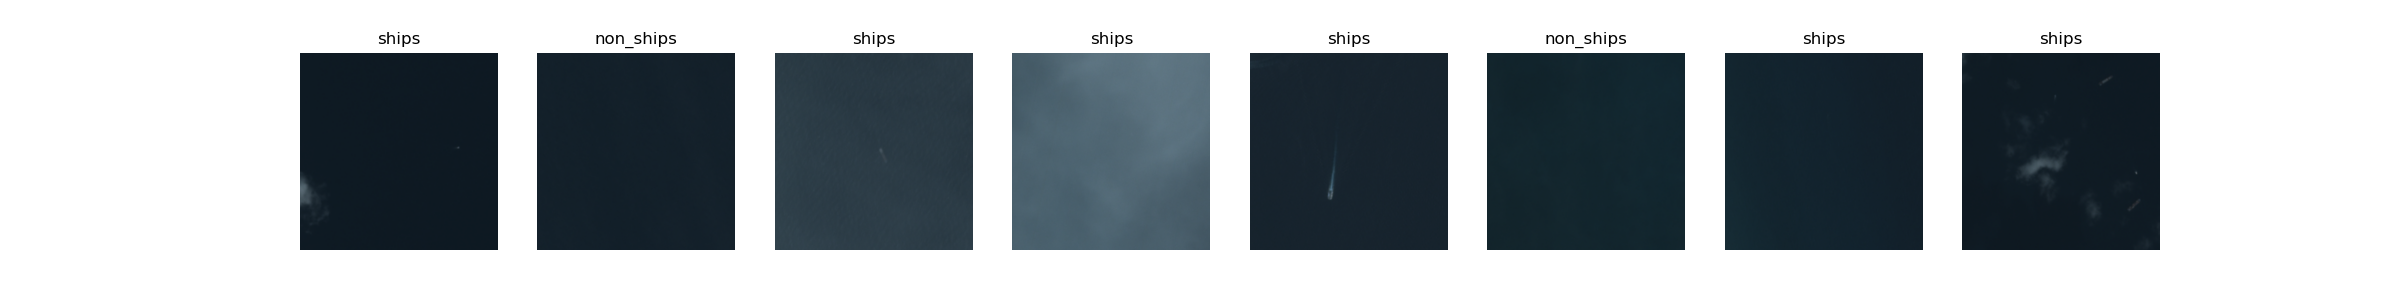

In [85]:
dls=images.dataloaders(image_path)
dls.valid.show_batch(max_n=8, nrows=1)


UsageError: %%debug is a cell magic, but the cell body is empty. Did you mean the line magic %debug (single %)?


In [ ]:
show_batch??

In [ ]:
Path('D:\Bachelor\data\ImageFiles\ships\189\20170526_150925_0f51_3B_AnalyticMS_clip.tif')

In [ ]:
get_image(r'D:\Bachelor\data\ImageFiles\ships\848\20171227_165654_1_0c59_3B_AnalyticMS_clip.tif')

## further tests

In [ ]:
nonship_images[5].shape


In [ ]:
show(ship_images[8].read(4))
np.max(ship_images[8].count)

In [ ]:
ship_images[7]

## Data Augmentation